## Trading Strategy - Time Return Trend Model

策略核心理念：
- 策略核心目標是追蹤長期趨勢，避免因短期波動而提早出場。
- 實際執行策略條件：1.需要大量的資金。2.特定時間會持有大量股票部位。3.槓桿比率低(high margin to equity ratio)。 


### 一. 環境設定 & import package

1.1 輸入tejapi key

In [1]:
import os
os.environ['TEJAPI_KEY'] = "Your Key" 
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"

1.2 import package

In [2]:
import pandas as pd
import numpy as np
import pytz
# from datetime import datetime
import matplotlib.pyplot as plt
# import matplotlib

import zipline
from zipline.data import bundles
from zipline.utils.calendar_utils import get_calendar

from zipline.api import    *
from zipline.finance.commission import PerDollar,PerShare, PerTrade, PerContract
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage, VolatilityVolumeShare

from zipline.sources.TEJ_Api_Data import (get_Treasury_Return,
                                          get_Benchmark_Return)

from zipline.utils.run_algo import  (get_transaction_detail,
                                     #get_data_for_alphalens,
                                     get_record_vars)
import pyfolio as pf

### 二、樣本&期間

2.1 設定股票池與期間
- 股票池：輸入81檔權值股與加權股價報酬指數(IR0001)
- 期間：從2012-2022年

In [3]:
# set stocklist---------------------------------------------------
StockList = \
['1101', '1102', '1216', '1301', '1303', '1326', '1402', '1722', '2002', '2105', '2201', '2207', '2301',
 '2303', '2308', '2311', '2317', '2324', '2325', '2330', '2347', '2353', '2354', '2357', '2382', '2409',
 '2412', '2454', '2474', '2498', '2801', '2880', '2881', '2882', '2883', '2885', '2886', '2890', '2891',
 '2892', '2912', '3008', '3045', '3231', '3481', '3673', '3697', '4904', '5880', '6505', '2884', '4938',
 '2887', '2227', '9904', '3474', '2395', '2408', '1476', '2823', '2633', '5871', '2327', '3711', '2492',
 '5876', '9910', '2888', '6669', '2379', '6415', '3034', '1590', '8046', '2603', '2609', '2615', '8454',
 '3037', '6770', '1605', 'IR0001']


# set backtest period----------------------------------------------
start='2012-01-01'
end='2023-07-30'

start_dt, end_dt = pd.Timestamp(start, tz = pytz.utc), pd.Timestamp(end, tz = pytz.utc)

2.2 樣本與期間設定輸入，並利用tejapi將開高低收量、調整股價資料綁入zipline
- 綁入名稱為`tquant的資料庫`，並指定交易日為`台股交易日誌:TEJ_XTAI`

In [4]:
os.environ['ticker'] = ' '.join(StockList)
os.environ['mdate'] = start+' '+end

In [5]:
!zipline ingest -b tquant

Merging daily equity files:


[2023-11-03 03:34:32.395606] INFO: zipline.data.bundles.core: Ingesting tquant.


In [6]:
# calendar------------------------------------------
calendar_name='TEJ_XTAI'  
# bundle_name---------------------------------------
bundle_name = 'tquant'

### 三、建構交易策略
交易策略包含：進出場規則設定、持股配置、交易頻率，以及交易費用設定
- **進出場規則**
    - 進場rule
        - Long Entry:
            - 今日股票價格比半年前和一年前股價高，買進股票。            
        - Short Entry:
            - 今日股票價格比半年前和一年前股價低，放空股票。            
    - 出場rule
        - Long Exit:
            - 今日股票價格比半年前和一年前股價低，賣出股票。            
        - Short Exit:
            - 今日股票價格比半年前和一年前股價高，回補股票。
    
- **持股配置**
    - 旨要利用配置與調整持股權重，使每檔股票對策略每日風險的貢獻程度大致均等。
    - 由於不同股票其價格波動的幅度差異很大，若以等權重配置會使策略的風險高度偏斜於波動大個股票。
    - 本範例會利用近期股價波動的標準差來衡量風險，作為調整持股配置的依據。
    
- **交易頻率**
    - 交易頻率設定為月頻。每月月初確認交易訊號，決定買賣股票與調整持股部位。    - 
    
- **交易費用**
    - 設定單次買賣股票金額的0.29%為佣金費用
    - 設定0%為滑價成本 
   


3.1 交易策略參數設定

In [7]:
# These lines are for the dynamic text reporting
from IPython.display import display
import ipywidgets as widgets
out = widgets.HTML()
display(out)

"""
Model Settings
"""
starting_portfolio = 1e6
risk_factor = 1
vola_window = 60
short_trend_window = 125
long_trend_window = 250

'''
cost params setting
'''
commission_pct = 0.0029
slippage_volume_limit = 1.0
slippage_impact = 0

HTML(value='')

3.2 交易策略初始化設定

In [8]:
def initialize(context):

    # trading cost setting-----------------------------------------------------------------------------
    set_commission(PerDollar(cost=commission_pct))
    set_slippage(VolumeShareSlippage(volume_limit=slippage_volume_limit, price_impact=slippage_impact)) 
     
    # Make a list of all continuations-----------------------------------------------------------------
    bundle_data = bundles.load('tquant')
    context.universe = bundle_data.asset_finder.retrieve_all(bundle_data.asset_finder.equities_sids)
    
    # setting benchmark
    set_benchmark(symbol('IR0001'))     
     
    # We'll just use this for the progress output
    # during the backtest. Doesn't impact anything.
    context.months = 0    
    
    # Schedule daily trading 
    schedule_function(rebalance, date_rules.month_start(), time_rules.market_close())
    
    # Schedule monthly chart update
    schedule_function(update_chart,date_rules.week_end(), time_rules.market_close())  #month_start

3.3 持股配置與進出場規則設定

In [9]:
def update_chart(context,data):
    # This function continuously update the graph during the backtest
    today = data.current_session.date()
    dynamic_results.loc[today, 'PortfolioValue'] = context.portfolio.portfolio_value
    
    if ax.lines: # Update existing line
        ax.lines[0].set_xdata(dynamic_results.index)
        ax.lines[0].set_ydata(dynamic_results.PortfolioValue)
    else: # Create new linef
        ax.semilogy(dynamic_results)
        
    # Update scales min/max
    ax.set_ylim(
        dynamic_results.PortfolioValue.min(),
        dynamic_results.PortfolioValue.max()
    )
    ax.set_xlim(
        dynamic_results.index.min(),
        dynamic_results.index.max()
    )
    
    # Redraw the graph
    fig.canvas.draw()
    
def position_size(portfolio_value, std, point_value=1):
    risk_factor = 0.01
    target_variation = portfolio_value * risk_factor
    contract_variation = std * point_value
    contracts = target_variation / contract_variation
    return int(np.nan_to_num(contracts)) 

def rebalance(context, data):    
    
    today = data.current_session.date()  
    todays_universe = context.universe
    
    hist_close = data.history(todays_universe, ['close','volume'], bar_count=long_trend_window  + 1, frequency='1d')['close']
    hist_volume = data.history(todays_universe, ['close','volume'], bar_count=long_trend_window  + 1, frequency='1d')['volume']    
        
    for _asset in todays_universe:
        
        h_close = hist_close.unstack()[_asset]
        h_volume = hist_volume.unstack()[_asset]
        h_std = hist_close.unstack().pct_change().iloc[-vola_window:].std()[_asset]*100 
        
        if _asset in context.portfolio.positions:
            
            p = context.portfolio.positions[_asset]
            
            if p.amount > 0: # Position is long
                if h_close.iloc[-1] < h_close.iloc[-long_trend_window]:
                    # Lost slow trend, close position
                    order_target(_asset, 0)
                elif h_close.iloc[-1] < h_close.iloc[-short_trend_window]:
                    # Lost fast trend, close position
                    order_target(_asset, 0)
 
            elif p.amount <0: # Short position
                if h_close.iloc[-1] > h_close.iloc[-long_trend_window]:
                    # Lost slow trend, close position
                    order_target(_asset, 0)
                elif h_close.iloc[-1] > h_close.iloc[-short_trend_window]:
                    # Lost fast trend, close position
                    order_target(_asset, 0)
                    
        else: # No position on
            if _asset==symbol('IR0001'): continue
            
            volume_to_trade = position_size(context.portfolio.portfolio_value, h_std,1)                   
            
            # Buy new position
            if (h_close[-1] > h_close[-long_trend_window]) and (h_close[-1] > h_close[-short_trend_window]):               
                order_value(_asset, volume_to_trade) 
       
                   
            # New short position        
            elif (h_close[-1] < h_close[-long_trend_window]) and (h_close[-1] < h_close[-short_trend_window]):
                order_value(_asset, -volume_to_trade) 
              

3.4 取得Treasury資料，以第一銀行(5844)一年期定存利率作為無風險利率。

In [10]:
start = pd.Timestamp('2020-01-01', tz='utc'), 
end   = pd.Timestamp('2023-07-30', tz='utc'), 

treasury_returns = get_Treasury_Return(start = start_dt,
                                      end = end_dt,
                                      rate_type = 'Time_Deposit_Rate',                     
                                      term = '1y',
                                      symbol = '5844')
treasury_returns

mdate
2012-01-02 00:00:00+00:00    0.000053
2012-01-03 00:00:00+00:00    0.000053
2012-01-04 00:00:00+00:00    0.000053
2012-01-05 00:00:00+00:00    0.000053
2012-01-06 00:00:00+00:00    0.000053
                               ...   
2023-07-24 00:00:00+00:00    0.000062
2023-07-25 00:00:00+00:00    0.000062
2023-07-26 00:00:00+00:00    0.000062
2023-07-27 00:00:00+00:00    0.000062
2023-07-28 00:00:00+00:00    0.000062
Length: 2835, dtype: float64

3.5 執行回測

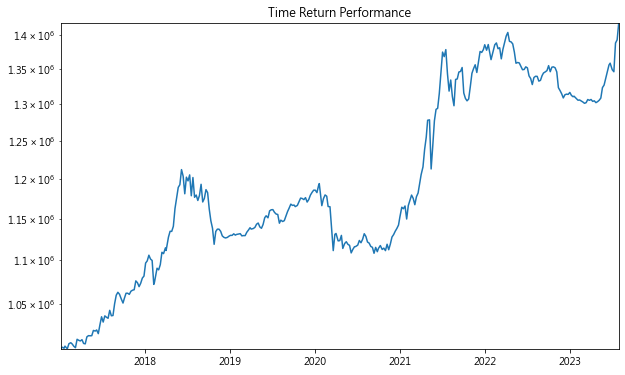

In [11]:
"""
Prepare for dynamic chart
"""
dynamic_results = pd.DataFrame()
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title('Time Return Performance')

results = zipline.run_algorithm(
                start = pd.Timestamp('2017-01-01', tz='utc'), 
                end   = pd.Timestamp('2023-07-30', tz='utc'), 
                initialize=initialize,                 
                capital_base=starting_portfolio,  
                data_frequency = 'daily', 
                treasury_returns=treasury_returns,
                trading_calendar=get_calendar(calendar_name),
                bundle=bundle_name)

### 4.策略績效分析
4.1 利用pyfolio分析評估策略的風險與報酬表現

Start date,2017-01-03
End date,2023-07-28
Total months,76
,Backtest
Annual return,5.659%
Cumulative returns,41.929%
Annual volatility,6.008%
Sharpe ratio,0.95
Calmar ratio,0.56
Stability,0.79
Max drawdown,-10.038%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.04,2018-06-07,2020-03-19,2021-04-12,693
1,7.87,2021-05-10,2021-05-17,2021-06-01,17
2,7.54,2022-04-06,2023-04-25,2023-07-26,320
3,7.01,2021-07-08,2021-08-19,2022-01-13,132
4,3.60,2018-01-22,2018-02-06,2018-03-16,33


Stress Events,mean,min,max
New Normal,0.02%,-3.12%,3.12%


Top 10 long positions of all time,max
sid,
2327,5.11%
2615,5.10%
2492,4.73%
2609,4.18%
3231,4.17%
2603,3.34%
4904,3.29%
2382,3.17%
8046,2.96%


Top 10 short positions of all time,max
sid,
2002,-1.93%
2201,-1.68%
1101,-1.62%
1303,-1.62%
2412,-1.60%
2227,-1.56%
3045,-1.56%
2609,-1.51%
2883,-1.50%


Top 10 positions of all time,max
sid,
2327,5.11%
2615,5.10%
2492,4.73%
2609,4.18%
3231,4.17%
2603,3.34%
4904,3.29%
2382,3.17%
8046,2.96%


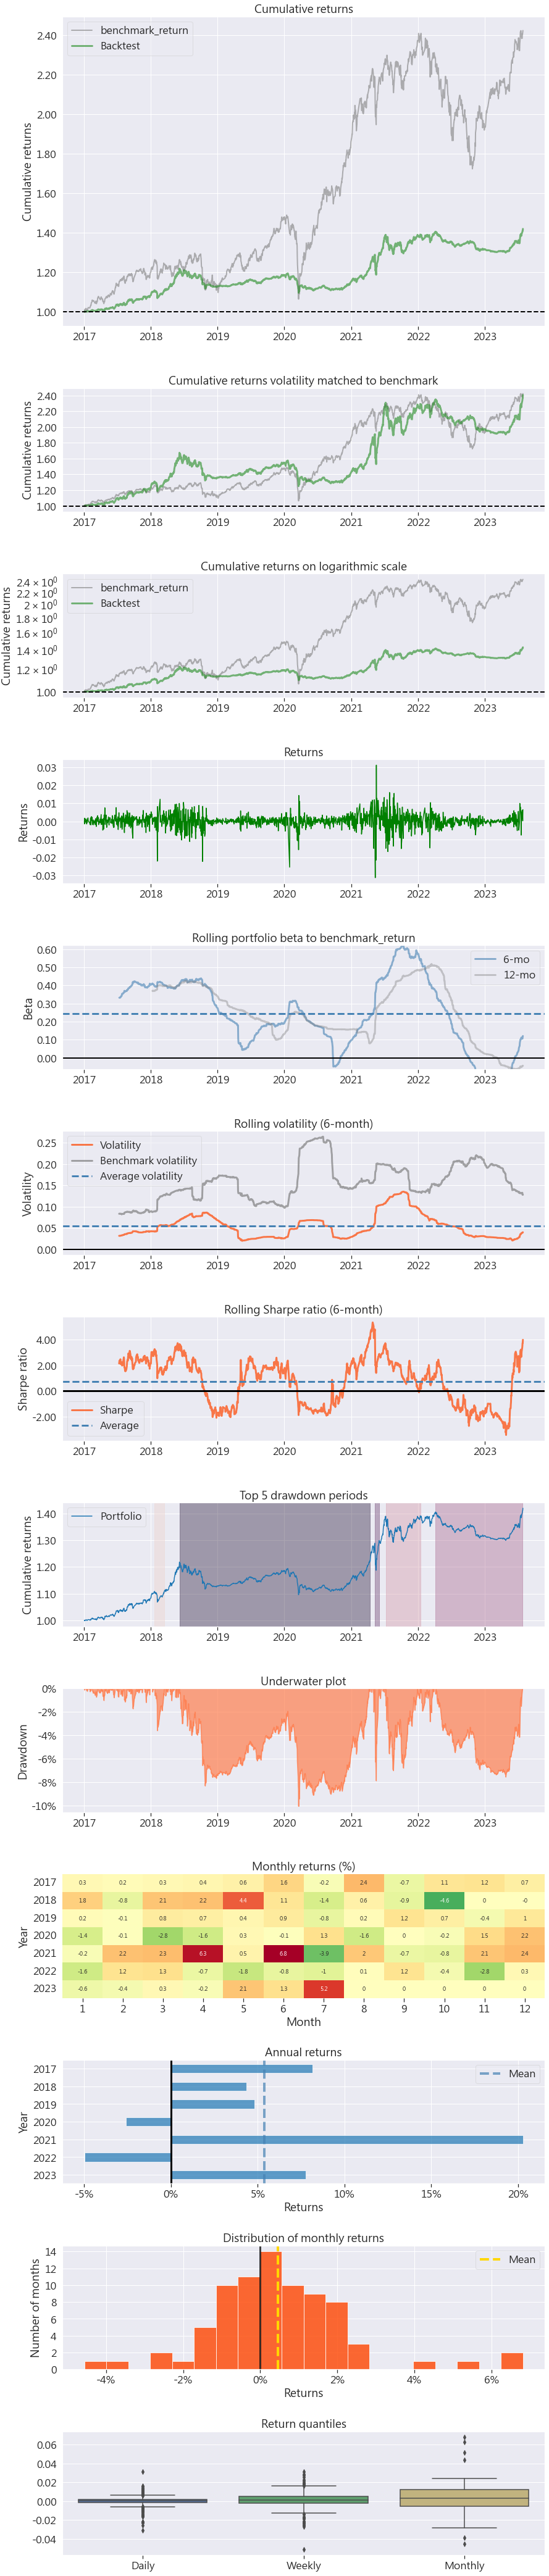

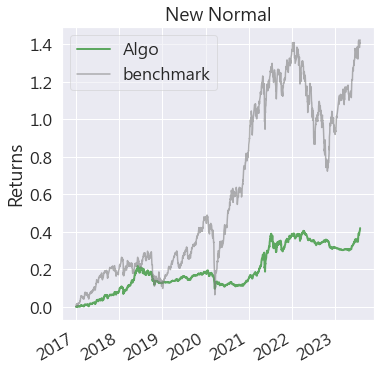

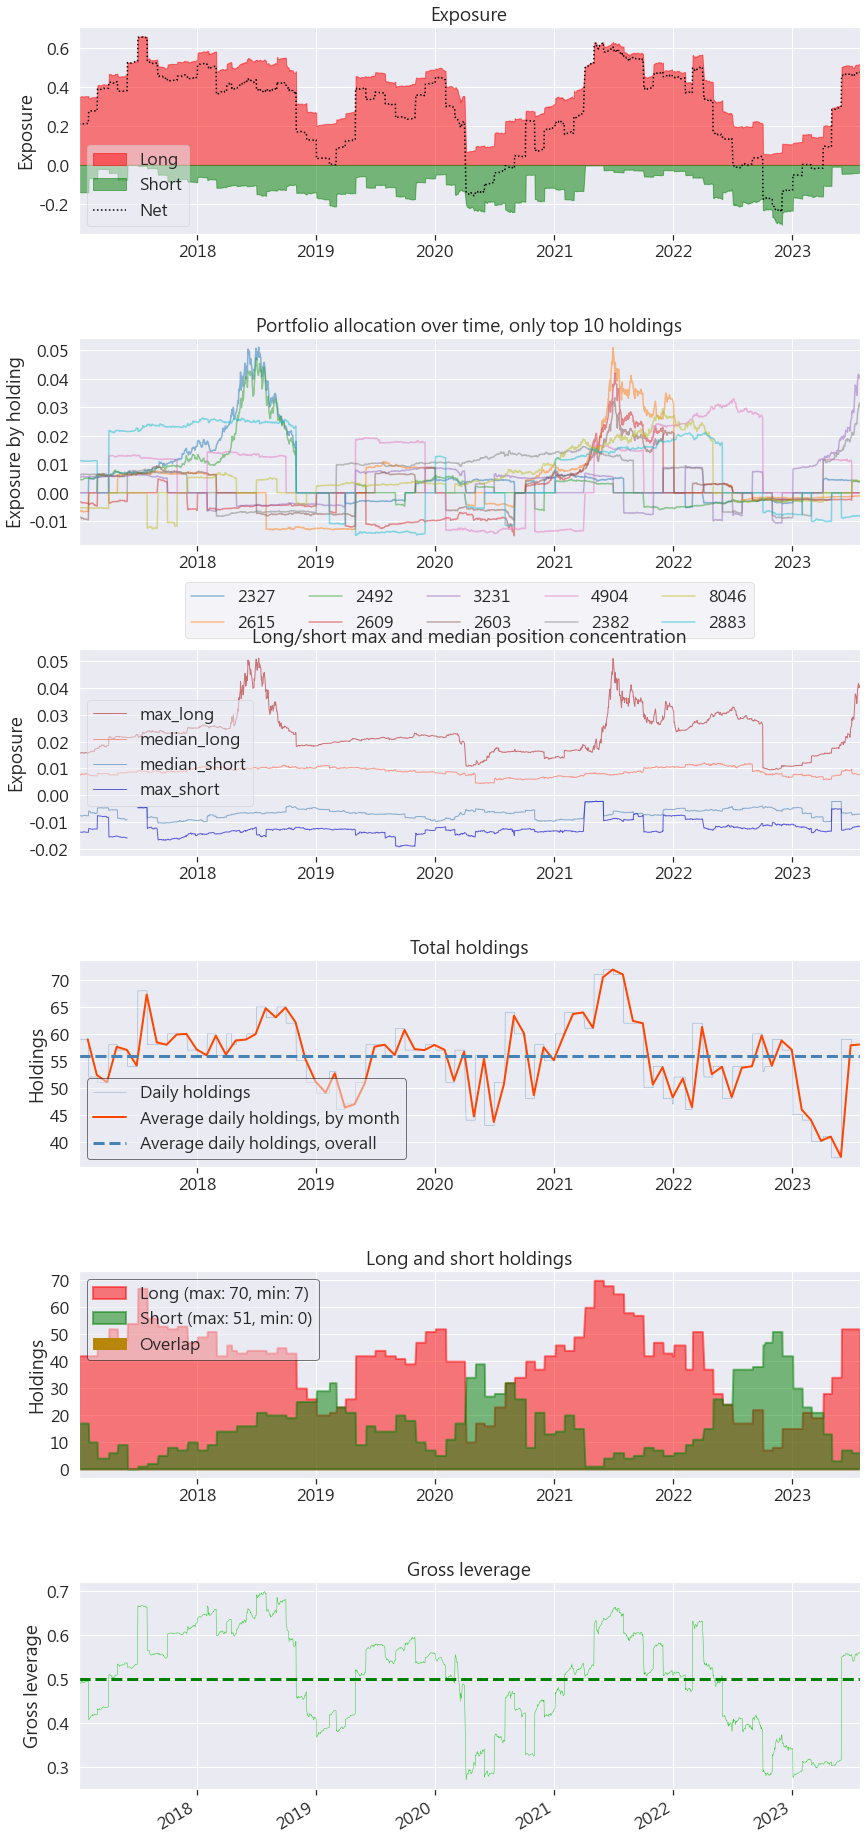

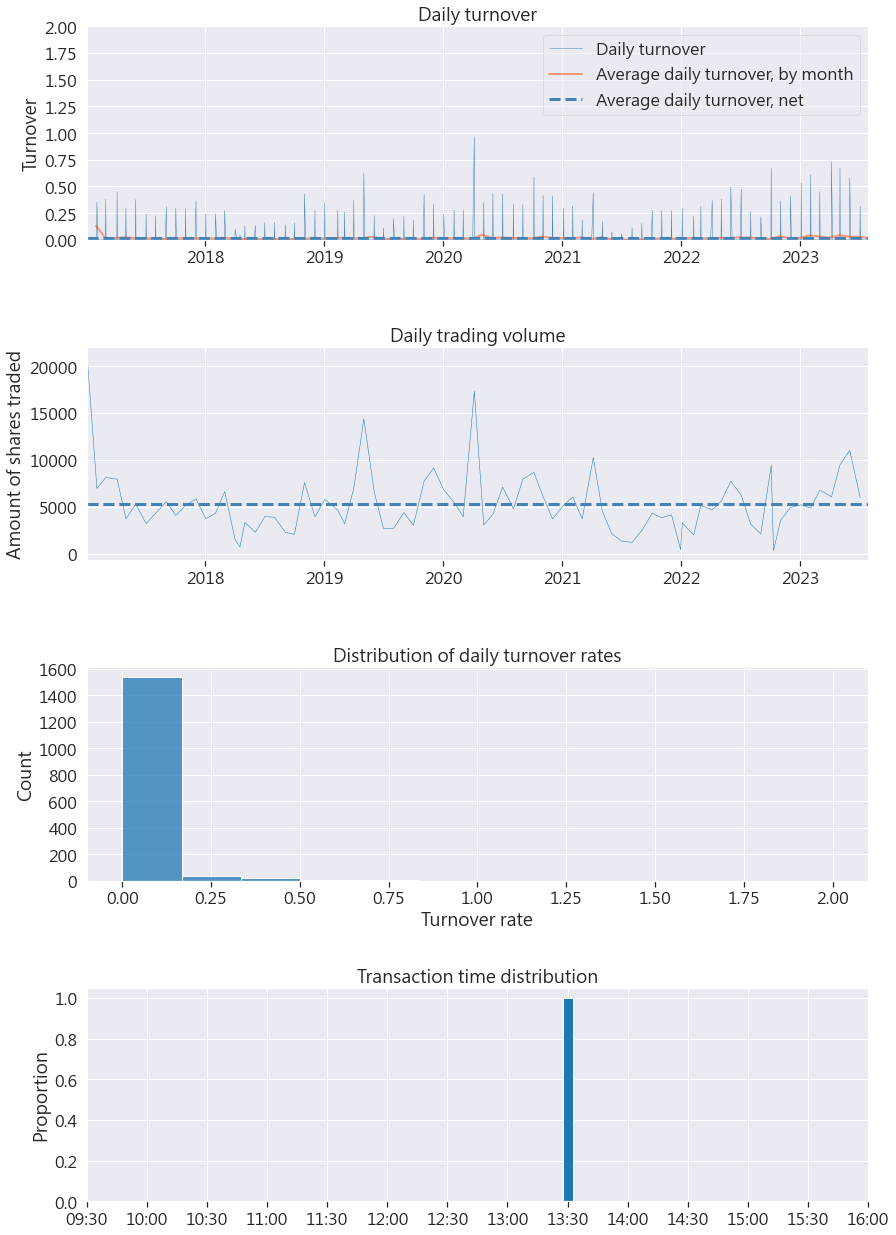

In [12]:
import pyfolio as pf
import empyrical

bt_returns, bt_positions, bt_transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

bt_returns.index = bt_returns.index.tz_localize(None).tz_localize('UTC')
bt_positions.index = bt_positions.index.tz_localize(None).tz_localize('UTC')
bt_transactions.index = bt_transactions.index.tz_localize(None).tz_localize('UTC')
benchmark_rets.index = benchmark_rets.index.tz_localize(None).tz_localize('UTC')

# Creating a Full Tear Sheet
pf.create_full_tear_sheet(bt_returns, positions=bt_positions, transactions=bt_transactions,
                          benchmark_rets=benchmark_rets,
                          #live_start_date='2022-01-01', 
                          round_trips=False)

4.2 整理交易細節：positions／transactions／orders資訊


In [13]:
positions, transactions, orders = get_transaction_detail(results)
positions

,sid,symbol,asset,amount,cost_basis,last_sale_price
2017-01-04 00:00:00+08:00,0,1101,Equity(0 [1101]),183,35.352225,35.25
2017-01-04 00:00:00+08:00,1,1102,Equity(1 [1102]),-287,26.273585,26.35
2017-01-04 00:00:00+08:00,2,1216,Equity(2 [1216]),-144,52.846300,53.00
2017-01-04 00:00:00+08:00,3,1301,Equity(3 [1301]),101,90.561870,90.30
2017-01-04 00:00:00+08:00,4,1303,Equity(4 [1303]),127,71.907930,71.70
...,...,...,...,...,...,...
2023-07-28 00:00:00+08:00,37,2492,Equity(37 [2492]),57,96.880140,95.70
2023-07-28 00:00:00+08:00,49,2884,Equity(49 [2884]),874,25.170000,25.95
2023-07-28 00:00:00+08:00,60,3037,Equity(60 [3037]),29,180.522000,191.00
2023-07-28 00:00:00+08:00,71,5876,Equity(71 [5876]),-362,46.016165,44.25
